In [ ]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from glob import glob
import pydicom as dicom
from skimage.segmentation import clear_border
from skimage.morphology import binary_closing, disk
from skimage.morphology import remove_small_objects
from skimage.measure import label,regionprops

In [ ]:
## Load Data
testDir = r"C:\Users\Ann\Downloads\stage_2_test_images"
trainDir = r"C:\Users\Ann\Downloads\stage_2_train_images"

#get len of test and train folders, should be 3000, ~26,000
def filelen(dir):
    count = 0
    for path in os.listdir(dir):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir, path)):
            count += 1
    return count
#test
print(filelen(testDir),filelen(trainDir))

#puts all file names in an array 
def dir2Array(dir):
    returnarr = [None] * filelen(dir)
    count = 0
    for entry in os.scandir(dir):
        if entry.is_file():
            returnarr[count] = dicom.dcmread(f"{entry.path}").pixel_array
        count = count + 1
    return returnarr
    #plot images using this repeatedly for testing

def plotImgs(arr,row,col):
    fig,axes = plt.subplots(row,col)
    for i, ax in enumerate(axes.flat):
        ax.imshow(arr[i], cmap = plt.cm.gray) 
        ax.axis('off') 
    plt.tight_layout()
    plt.show()



3000 26684


In [4]:
# run separately for time
testds = dir2Array(testDir)

In [ ]:
# trainds = dir2Array(trainDir)

RuntimeError: Unable to decode as exceptions were raised by all available plugins:
  pillow: 

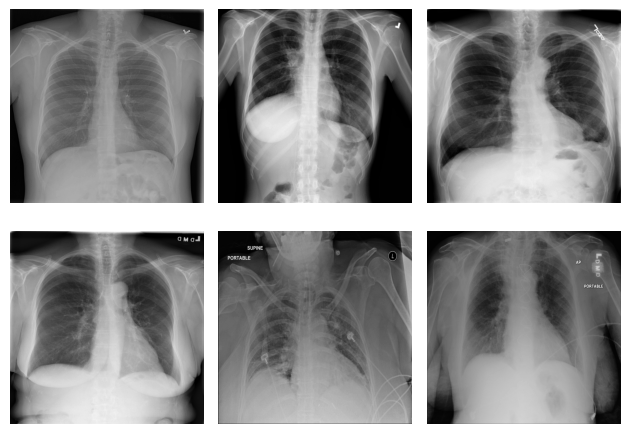

In [5]:
plotImgs(testds,2,3)

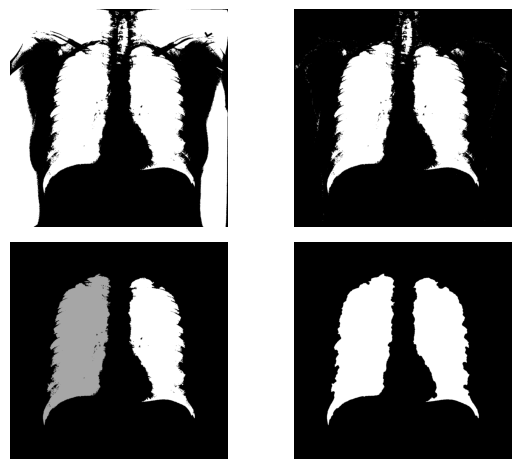

243411


In [ ]:
#Segmentation and filtering
image = testds[0].astype(float)

def ridTrach(cleared):
    label_img = label(cleared)
    numregion = len(regionprops(label_img))
    regions = (regionprops(label_img))
    idxsize = 5000
    while numregion != 2:
        if numregion > 2:
            idxsize = idxsize + 1000
            label_img = remove_small_objects(label_img, min_size = idxsize)
            numregion = len(regionprops(label_img))
        elif numregion == 2:
            idxsize = idxsize
            label_img = remove_small_objects(label_img, min_size = idxsize)
        else:
            print("you messed up")
        break
    return label_img,regions

#segmentation for top part of lung
def segLungTop(img):
    thresh_val = 115
    binary_image = img < thresh_val
    cleared = clear_border(binary_image)
    #remove trachea and small holes
    filtered,regions = ridTrach(cleared)
    # #smooteh image
    smoothed = binary_closing(filtered, footprint=disk(5))
    array2plot  = [binary_image,cleared,filtered,smoothed]
    return smoothed,regions, array2plot

def getarea(boolimg):
    return boolimg.sum()

finimg,regions,imgarray = segLungTop(image)
lungarea = getarea(finimg)
plotImgs(imgarray,2,2)
print(lungarea)

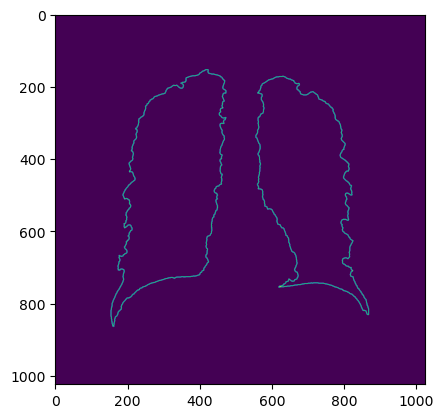

In [97]:
import skimage as ski
img = ski.filters.sobel(finimg)
plt.imshow(img)

In [119]:
intfinimg = np.array(finimg, dtype = np.uint8)
print( intfinimg)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


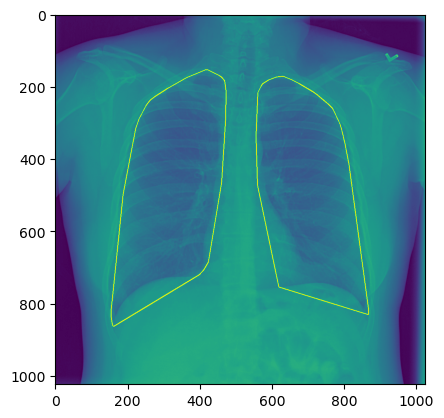

In [120]:
from PIL import Image, ImageFilter
import scipy as sci

contours, hierarchy = cv2.findContours(intfinimg, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approximatedShape = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
for contour in contours:
    convexHull = cv2.convexHull(contour)
    cv2.drawContours(image, [convexHull], -1, (255, 0, 0), 2)

# Display the final convex hull image

plt.imshow(image)